In [1]:
#!pip install pandas
#!pip install matplotlib
#!pip install statsmodels
#!pip install scikit-learn
#!pip install seaborn

In [2]:
from pathlib import Path
import sys
# Agregar el path del directorio "code"
code_path = Path("../code").resolve()
if str(code_path) not in sys.path:
    sys.path.insert(0, str(code_path))

In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
from utils import get_channel
from CustomTransformers import TimeSeriesFreqRegularization
from utils import rolling_forecast
mission_name = 'ESA-Mission1'
channel_name = "channel_44"
channel = get_channel(mission_name, channel_name)

ModuleNotFoundError: No module named 'utils'

In [ ]:
df = channel["data"]

In [25]:
#df = df.asfreq(pd.infer_freq(df.index))

Si tomo muchos datos me da que la serie es estacionaria, pero...tiene estacionalidad no contemplada y eso parece ser un problema, por tanto tomo una cantidad de datos pequeños

Regularizo la serie de tiempos :(

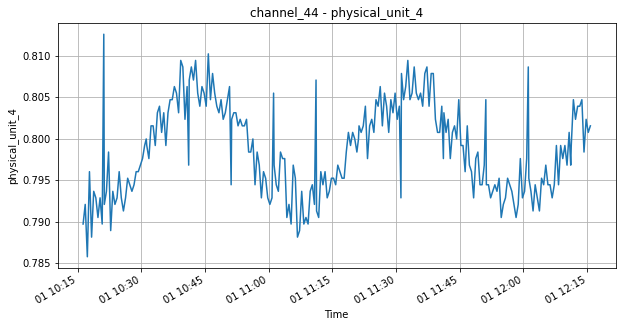

In [ ]:
dt_from = '2000-01-01 10:16:00'
dt_to   = '2000-01-01 12:16:00'
ldf = df[(df.index >= dt_from) & (df.index <= dt_to)]
plt.figure(figsize=(10, 5))
plt.plot(ldf.index, ldf[channel_name], label=channel["Channel"])
plt.title(channel["Channel"] + " - " + channel["Physical Unit"])
plt.xlabel("Time")      
plt.ylabel(channel["Physical Unit"])
#plt.set_major_locator(mdates.DayLocator(interval=7))  # cada 7 días
plt.gcf().autofmt_xdate()  # Ajusta las fechas automáticamente
plt.grid()
plt.show()


In [27]:
tsr = TimeSeriesFreqRegularization(columns=[channel_name])
tsr.fit(ldf)
print(f"Frecuencia: {tsr.most_frequent_frequency_}s")
ldf = tsr.transform(ldf)

Frecuencia: 30s


## Primera pregunta. ¿Es estacionaria la serie?
### Aplicamos ADF

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(ldf[channel_name])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.5551479933418793
p-value: 0.10262603946484283


No rechazamos la hipótesis nula de que la serie tiene una raíz unitaria y por tanto no es estacionaria. Debemos obtener la diferencia de primer orden. 

In [ ]:
ldf.loc[:,['values_diff']] = ldf[channel_name].diff()
#Elimino el primero, lo pierdo
ldf.dropna(inplace=True)

Dibujamos valores y diferencia orden 1

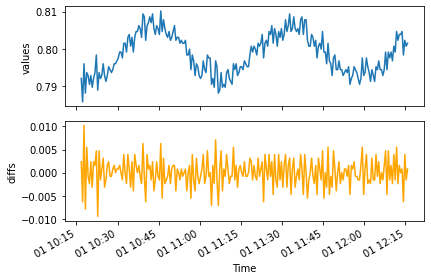

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(ldf[channel_name])
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
#ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(ldf['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
#ax2.axvspan(449, 498, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()
plt.show()

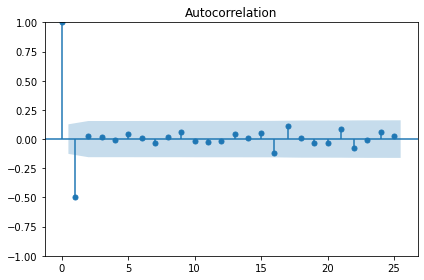

In [ ]:
#El primer elemento es NaN, por eso no lo consideramos
plot_acf(ldf["values_diff"], lags=25)
plt.tight_layout()
plt.show()
#MA(22)?

¿Es un autoregresivo? Parece que no, acf dice que es un moving average